In [7]:
import siganalysis as sa
import numpy as np
from numpy import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import math
from scipy.fftpack import *
import scipy
import pandas as pd

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm

In [60]:
# Functions
def get_data():
    data_sit = pd.read_csv('results/sitting.csv', header=None)
    data_walk = pd.read_csv('results/walking.csv', header=None)
    data = data_sit.append(data_walk)
    train_data, test_data = train_test_split(data, test_size=0.8)
    train_labels = train_data[6]
    train_data = train_data.drop(6, axis=1)
    test_labels = test_data[6]
    test_data = test_data.drop(6, axis=1)
    labels = data[6]
    data = data.drop(6, axis=1)
    return data, labels, train_data, train_labels, test_data, test_labels

def readData(label,feature):
    suffix = '.csv'
    filename = os.path.join('Data/csv/',label,feature+suffix)
    dataframe = pd.read_csv(filename,header=None)
    dataframe.columns = ['id','x','y','z','a','label']
    return dataframe

def stft(x, fftsize=256, overlap=2):   
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

def feature(x, fftsize=256, overlap=2):
    meanamp = []
    maxamp = []
    minamp = []
    stdamp = []
    energyamp = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        meanamp.append(np.array(np.mean(x[i:i+fftsize])))
        maxamp.append(np.array(np.max(x[i:i+fftsize])))
        minamp.append(np.array(np.min(x[i:i+fftsize])))
        stdamp.append(np.array(np.std(x[i:i+fftsize])))
        energyamp.append(np.array(np.sum(np.power(x[i:i+fftsize],2))))
             
    return meanamp ,maxamp ,minamp,stdamp,energyamp

def normalize_feat(valmean, valmax, valmin, valstd, valenergy, energy_signal):
    valmean_nor = ((valmean) - min(valmean))/(max(valmean) - min(valmean))
    valmax_nor = ((valmax) - min(valmax))/(max(valmax) - min(valmax))
    valmin_nor = ((valmin) - min(valmin))/(max(valmin) - min(valmin))
    valstd_nor = ((valstd) - min(valstd))/(max(valstd) - min(valstd))
    valenergy_nor = ((valenergy) - min(valenergy))/(max(valenergy) - min(valenergy))
    energy_signal_nor = ((energy_signal) - min(energy_signal))/(max(energy_signal) - min(energy_signal))
    return valmean_nor, valmax_nor, valmin_nor, valstd_nor, valenergy_nor, energy_signal_nor

In [10]:
def compute_feats(*dataframes):
    label = {}
    for counter, data in enumerate(dataframes):
        time, x, y, z, _, str_label = np.array(data[0]), np.array(data[1]), np.array(data[2]), np.array(data[3]), np.array(data[4]), np.array(data[5])
        label[str_label[0]] = counter
        mpre = x*x+y*y+z*z
        m = np.sqrt(mpre)
        m_smooth = np.zeros(len(m))
        m_smooth = m;

        for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
            m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] +m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
            m = m_smooth

        plt.plot(m)
        plt.show()

        ####################################################################################
        stft_signal = stft(m)
        energy_signal = []

        for i, amp in enumerate(stft_signal):
            energy_signal.append(np.sum(np.power(abs(stft_signal[i]),2)))

        ####################################################################################
        valmean ,valmax,valmin,valstd,valenergy= feature(m)
        diff = np.subtract(valmax,valmin)

        plt.plot(m)
        plt.xlabel('Freq')
        plt.ylabel('Energy')
        plt.title(str_label[0])
        plt.show()
        ####################################################################################
        # Normalize
        valmean, valmax, valmin, valstd, valenergy, energy_signal = normalize_feat(valmean, valmax, valmin, 
                                                                                   valstd, valenergy, energy_signal)

        ####################################################################################
        # Save the extracted features.

        for i ,val in enumerate(valmean):
            saveFile = open ('results/' + str_label[0] +'.csv','a')
            saveFile.write(str(valmean[i]) + ',' +str(valmax[i]) + ',' + str(valmin[i]) + 
                           ',' + str(valstd[i]) + ',' + str(valenergy[i])+ ',' + str(energy_signal[i]) + 
                           ',' + str(label[str_label[0]]) )
            saveFile.write('\n')

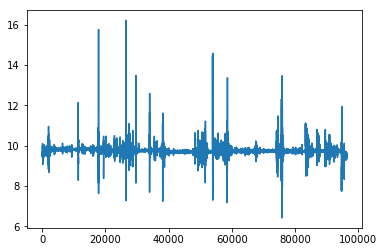

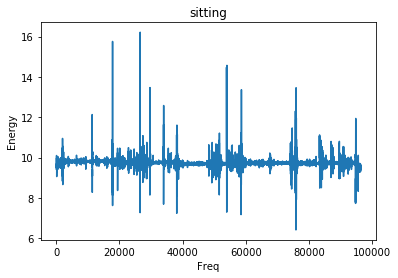

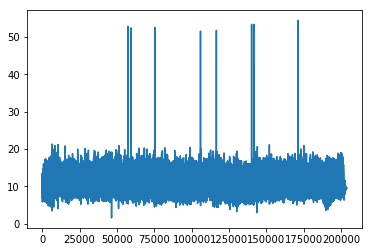

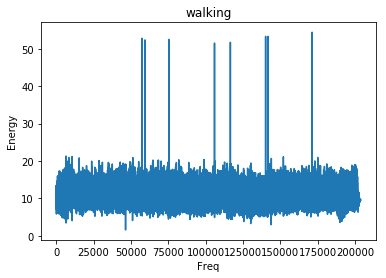

In [11]:
data_sit = pd.read_csv('Data/csv/sitting/accelerometer.csv', header=None)
data_walk = pd.read_csv('Data/csv/walking/accelerometer.csv', header=None)
compute_feats(data_sit, data_walk)

In [67]:
############## Random Forest Classifier ##############
search_best_params = False
data, labels, train_data, train_labels, test_data, test_labels = get_data()
if search_best_params:
    param_grid = { 
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
    CV_clf.fit(data, labels)
    print(CV_clf.best_params_)
    print('Most important Features are:', clf.feature_importances_, sep='')
else:
    clf = RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False) 
    clf.fit(train_data, train_labels)

y_pred = clf.predict(test_data)
print('Accuracy is:', accuracy_score(test_labels, y_pred))
target_names = ['Sitting', 'Walking']
print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))

Accuracy is: 0.990916377238
Classification Report:
              precision    recall  f1-score   support

    Sitting       1.00      0.97      0.99      1205
    Walking       0.99      1.00      0.99      2538

avg / total       0.99      0.99      0.99      3743

Confusion Matrix
 [[1173   32]
 [   2 2536]]


In [68]:
############## SVM ##############
search_best_params = False
data, labels, train_data, train_labels, test_data, test_labels = get_data()

if search_best_params:
    clf = svm.SVC()
    parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100]}
    clf = GridSearchCV(clf, parameters)
    clf.fit(data, labels) 
    print(clf.best_params_)
else:
    clf = svm.SVC(C=10, kernel='rbf')
    clf.fit(train_data, train_labels)

y_pred = clf.predict(test_data)
print('Accuracy is:', accuracy_score(test_labels, y_pred))
target_names = ['Sitting', 'Walking']
print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))

Accuracy is: 0.990382046487
Classification Report:
              precision    recall  f1-score   support

    Sitting       0.99      0.98      0.98      1197
    Walking       0.99      0.99      0.99      2546

avg / total       0.99      0.99      0.99      3743

Confusion Matrix
 [[1175   22]
 [  14 2532]]
